In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from os import path

In [3]:
folder_path = path.join('.','data')

In [4]:
doe = pd.read_excel(path.join(folder_path, 'doe_lhsmu_locked.xlsx'),
                    header = 0, usecols = 'A:J')

In [5]:
doe

,batch,layer_thickness,Oscillator,Recoat Speed,roller_speed,roller_rpm,drying speed,drying_power,saturation,binder_set_time
0,1,170.950131,1967.331486,78.906433,4.325408,195.740100,8.975193,57.789017,59.215849,4.682984
1,2,218.833816,2059.599336,61.607811,3.001314,277.268534,16.391061,59.744374,89.594092,9.374743
2,3,129.909640,1937.495407,43.603111,5.855950,169.602720,19.940300,39.618434,80.671603,8.926232
3,4,141.806415,1871.663699,90.385153,17.915776,160.335560,11.752588,71.820288,91.839952,9.035047
4,5,125.986854,2112.279386,52.067637,11.647734,265.095430,17.432956,57.658267,67.618446,5.008873
5,6,182.054056,1915.419886,49.989358,18.063779,159.688379,20.584630,56.055525,71.634277,6.000027
6,7,232.105460,2249.189809,34.536084,18.165614,121.983421,18.860261,33.439828,77.386161,8.357111
7,8,204.762362,1860.991867,82.582075,3.706464,165.153934,13.543527,71.229867,86.812612,7.835582
8,9,132.045855,2191.071114,42.085086,11.207913,166.566982,10.699830,28.378491,88.389223,10.755372
9,10,199.844960,2234.452147,65.517652,19.146047,226.675309,11.635889,52.300589,81.859788,7.265524


In [6]:
sample_dimension = pd.read_excel(path.join(folder_path, 'process_map_data.xlsx'),
                                 header = 0, usecols = 'A:E')

In [7]:
sample_dimension.head()

,batch,id,x,y,z
0,1,1,20.47,15.45,10.49
1,1,1,20.41,15.29,10.37
2,1,1,20.68,15.52,10.46
3,1,2,20.37,15.46,10.34
4,1,2,20.31,15.48,10.32


In [8]:
archimedes = pd.read_excel(path.join(folder_path, 'process_map_data_archimedes.xlsx'),
                                 header = 0, usecols = 'A:F')

In [9]:
archimedes.head()

,batch,id,dry weight,immersed weight,soaked weight,run
0,1,4.0,16.0628,14.3834,16.8908,1
1,1,4.0,16.0612,14.3735,16.8770,1
2,1,4.0,16.0562,14.3548,16.8385,1
3,2,2.0,16.7028,14.9509,17.5258,1
4,2,2.0,16.6986,14.9242,17.4925,1


In [10]:

liq_den = 783.8
ss316 = 8000

density = archimedes['dry weight']/(archimedes['soaked weight']-archimedes['immersed weight'])*liq_den/ss316

In [11]:
archimedes['density'] = density

In [12]:
archimedes = archimedes.join(doe.set_index('batch'), on='batch')

In [13]:
archimedes.head()

,batch,id,dry weight,immersed weight,soaked weight,run,density,layer_thickness,Oscillator,Recoat Speed,roller_speed,roller_rpm,drying speed,drying_power,saturation,binder_set_time
0,1,4.0,16.0628,14.3834,16.8908,1,0.627643,170.950131,1967.331486,78.906433,4.325408,195.740100,8.975193,57.789017,59.215849,4.682984
1,1,4.0,16.0612,14.3735,16.8770,1,0.628558,170.950131,1967.331486,78.906433,4.325408,195.740100,8.975193,57.789017,59.215849,4.682984
2,1,4.0,16.0562,14.3548,16.8385,1,0.633372,170.950131,1967.331486,78.906433,4.325408,195.740100,8.975193,57.789017,59.215849,4.682984
3,2,2.0,16.7028,14.9509,17.5258,1,0.635542,218.833816,2059.599336,61.607811,3.001314,277.268534,16.391061,59.744374,89.594092,9.374743
4,2,2.0,16.6986,14.9242,17.4925,1,0.637015,218.833816,2059.599336,61.607811,3.001314,277.268534,16.391061,59.744374,89.594092,9.374743


In [14]:
settings = doe.columns[1:]

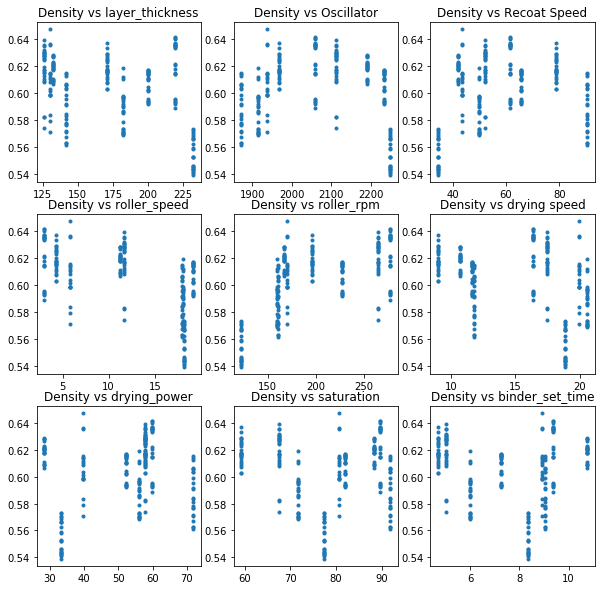

In [15]:
fig, axs = plt.subplots(3,3, figsize = (10,10))

for ax,param in zip(axs.flatten(),settings):
    ax.plot(archimedes[param],archimedes['density'],'.')
    ax.set_title('Density vs {}'.format(param))

plt.show()

In [16]:
dimension = pd.read_excel(path.join(folder_path, 'process_map_data.xlsx'),
                                 header = 0, usecols = 'A:E')

In [17]:
dimension['x'] = abs(dimension['x'] - 20.0)
dimension['y'] = abs(dimension['y'] - 15.0)
dimension['z'] = abs(dimension['z'] - 10.0)

In [18]:
dimension.head()

,batch,id,x,y,z
0,1,1,0.47,0.45,0.49
1,1,1,0.41,0.29,0.37
2,1,1,0.68,0.52,0.46
3,1,2,0.37,0.46,0.34
4,1,2,0.31,0.48,0.32


In [19]:
max_agg = dimension.groupby(['batch','id']).max()

In [20]:
max_agg = max_agg.join(doe.set_index('batch'), on='batch')

In [21]:
max_agg.head()

x     y     z  layer_thickness   Oscillator  Recoat Speed  \
batch id                                                                 
1     1   0.68  0.52  0.49       170.950131  1967.331486     78.906433   
      2   0.64  0.61  0.34       170.950131  1967.331486     78.906433   
      3   0.68  0.47  0.47       170.950131  1967.331486     78.906433   
      4   0.99  0.72  0.46       170.950131  1967.331486     78.906433   
      5   0.67  0.41  0.44       170.950131  1967.331486     78.906433   

          roller_speed  roller_rpm  drying speed  drying_power  saturation  \
batch id                                                                     
1     1       4.325408    195.7401      8.975193     57.789017   59.215849   
      2       4.325408    195.7401      8.975193     57.789017   59.215849   
      3       4.325408    195.7401      8.975193     57.789017   59.215849   
      4       4.325408    195.7401      8.975193     57.789017   59.215849   
      5       4.325408    195.7401      8.975193     57.789017   59.215849   

          binder_set_time  
batch id                   
1     1          4.682984  
      2          4.682984  
      3          4.682984  
      4          4.682984  
      5          4.682984

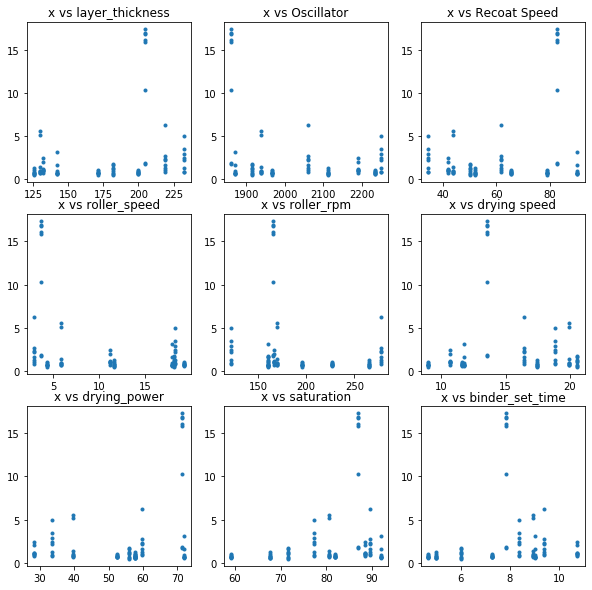

In [22]:
fig, axs = plt.subplots(3,3, figsize = (10,10))

for ax,param in zip(axs.flatten(),settings):
    ax.plot(max_agg[param],max_agg['x'],'.')
    ax.set_title('x vs {}'.format(param))

plt.show()

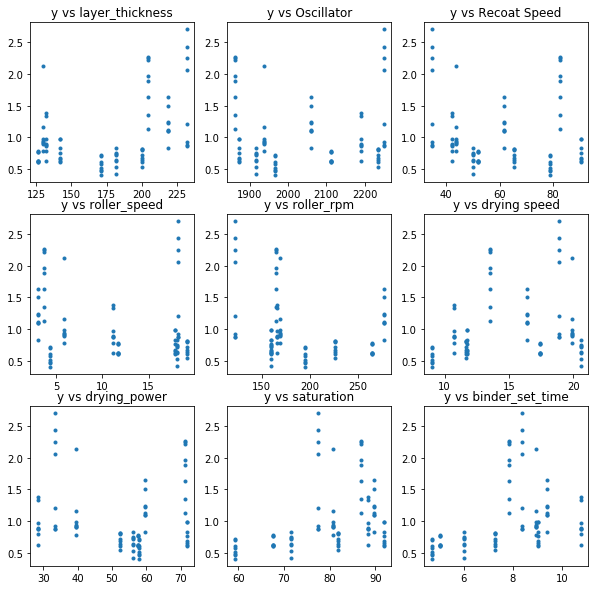

In [23]:
fig, axs = plt.subplots(3,3, figsize = (10,10))

for ax,param in zip(axs.flatten(),settings):
    ax.plot(max_agg[param],max_agg['y'],'.')
    ax.set_title('y vs {}'.format(param))

plt.show()

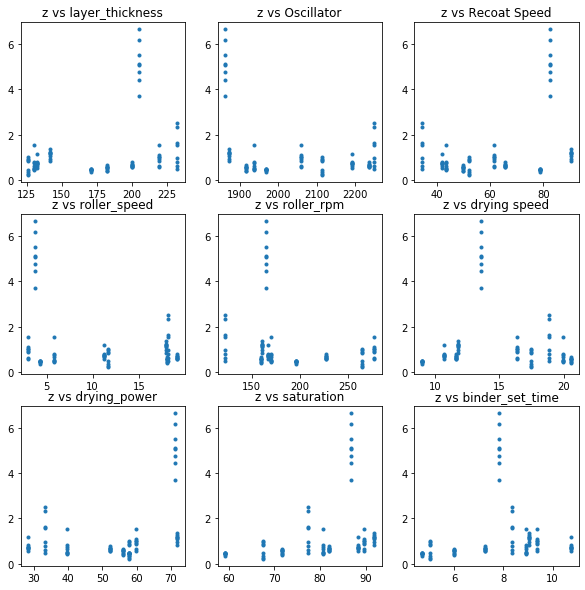

In [24]:
fig, axs = plt.subplots(3,3, figsize = (10,10))

for ax,param in zip(axs.flatten(),settings):
    ax.plot(max_agg[param],max_agg['z'],'.')
    ax.set_title('z vs {}'.format(param))

plt.show()

In [25]:
import sklearn.gaussian_process as gp
import optuna
from sklearn.model_selection import cross_val_score

data = archimedes.iloc[:,6:].to_numpy()

In [29]:
from sklearn import preprocessing

x_min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = x_min_max_scaler.fit_transform(data[:,1:])
y = data[:,0]

In [30]:
def gp_hyp_tuning(X, y):
    def objective(trial):

        ct = trial.suggest_uniform('constant kernel', 1e-3, 1.0)
        ls = trial.suggest_uniform('length scale', 1e-1, 150)
        nu = trial.suggest_uniform('nu', 1.0, 3.0)
        noise = trial.suggest_uniform('noise', 1e-5, 1.0)
        
        kernel = gp.kernels.ConstantKernel(ct)*gp.kernels.Matern(length_scale=ls, length_scale_bounds=(1e-1, 10000), nu=nu)
        regressor = gp.GaussianProcessRegressor(kernel=kernel, alpha = noise**2, n_restarts_optimizer=50)
        
        cross_val = cross_val_score(regressor, X, y, cv = 10)
        
        trial.set_user_attr('std', np.std(cross_val))
        
        return np.mean(cross_val)
    return objective


hype_tune_func = gp_hyp_tuning(X_scaled, y)

In [32]:
from sqlalchemy import create_engine

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(study_name='hype tune gp', direction='maximize', 
                            storage = 'sqlite:///data/hyp_tune.db',
                           load_if_exists=True)



In [33]:
study.optimize(hype_tune_func, n_trials=100, n_jobs = 1)

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\users\inst\.conda\envs\pyro\lib\site-packag

KeyboardInterrupt: 

In [34]:
study.best_trial

FrozenTrial(number=229, value=0.3282068067550785, datetime_start=datetime.datetime(2020, 3, 3, 6, 40, 16, 819852), datetime_complete=datetime.datetime(2020, 3, 3, 7, 4, 45, 767991), params={'constant kernel': 0.6553190222611792, 'length scale': 2373.3057540488776, 'noise': 0.02959040009791615, 'nu': 0.8954687274686358}, distributions={'constant kernel': UniformDistribution(high=1.0, low=0.001), 'length scale': UniformDistribution(high=10000, low=0.1), 'noise': UniformDistribution(high=5.0, low=1e-05), 'nu': UniformDistribution(high=3.0, low=0.1)}, user_attrs={'std': 0.4344983242363636}, system_attrs={'_number': 229}, intermediate_values={}, trial_id=230, state=TrialState.COMPLETE)

In [35]:
study.best_trial.params

{'constant kernel': 0.6553190222611792,
 'length scale': 2373.3057540488776,
 'noise': 0.02959040009791615,
 'nu': 0.8954687274686358}

In [38]:
from sklearn.model_selection import train_test_split

def create_regressor(trial):
    param = trial.params
    ct = param['constant kernel']
    ls = param['length scale']
    noise = param['noise']
    nu = param['nu']
    
    kernel = gp.kernels.ConstantKernel(ct)*gp.kernels.Matern(length_scale=ls, length_scale_bounds=(1e-1, 10000), nu=nu)
    regressor = gp.GaussianProcessRegressor(kernel=kernel, alpha = noise**2, n_restarts_optimizer=50)
    
    return regressor

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

optimal_regressor = create_regressor(study.best_trial)

optimal_regressor.fit(X_train,y_train)

pred_all, pred_std = optimal_regressor.predict(X_scaled, return_std = True)

c:\users\inst\.conda\envs\pyro\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [40]:
R_train_score = optimal_regressor.score(X_train, y_train)
R_test_score = optimal_regressor.score(X_test, y_test)

print("R**2 train : {}".format(R_train_score))
print("R**2 test : {}".format(R_test_score))

R**2 train : 0.6655466882359633
R**2 test : 0.6798162340878535


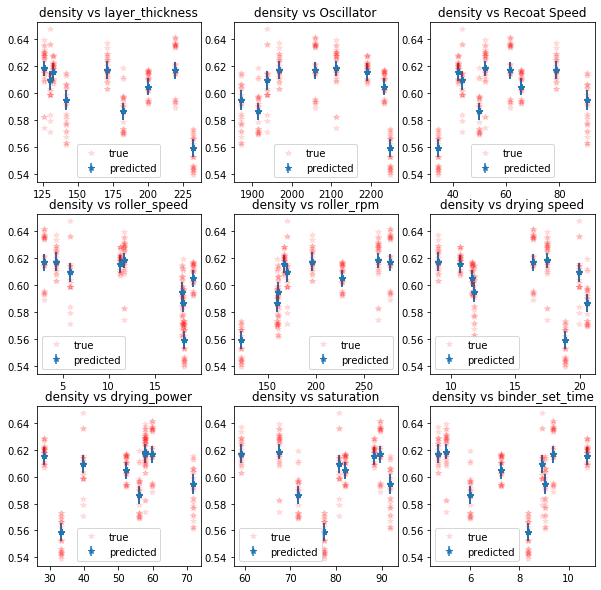

In [39]:

fig, axs = plt.subplots(3,3, figsize = (10,10))
for i, ax in enumerate(axs.ravel()):
    param = settings[i]
    ax.errorbar(data[:,i+1],pred_all, yerr = pred_std, 
                label = 'predicted', linestyle='None', marker='*')
    ax.plot(data[:,i+1],data[:,0], 'r*', label = 'true',
           alpha = 0.1)
    ax.legend()
    ax.set_title('density vs {}'.format(param))
plt.show()

In [47]:
def gp_to_maximize( regressor, scaler):
    
    def objective(trial):
        x = [[
            trial.suggest_uniform('layer_thickness', 100, 250),
            trial.suggest_uniform('oscillator', 1000, 2500),
            trial.suggest_uniform('recoat speed', 30, 100),
            trial.suggest_uniform('roller speed', 3, 30),
            trial.suggest_uniform('roller rpm', 80, 300),
            trial.suggest_uniform('drying speed', 5, 40),
            trial.suggest_uniform('drying powder', 20, 100),
            trial.suggest_uniform('saturation', 50,100),
            trial.suggest_uniform('bst', 0, 15)
        ]]
        
        x_scaled = scaler.transform(x)
        
        pred, std = regressor.predict(x_scaled, return_std = True)
        
        return pred
    return objective


obj_func = gp_to_maximize(optimal_regressor, x_min_max_scaler)

In [48]:
study_probe = optuna.create_study(study_name='probe gp', direction='maximize', 
                            storage = 'sqlite:///data/optuna.db',
                           load_if_exists=True)

study_probe.optimize(obj_func, n_trials=10)

In [49]:
study_probe.best_trial

FrozenTrial(number=755, value=0.6454389352553855, datetime_start=datetime.datetime(2020, 3, 3, 14, 20, 53, 505688), datetime_complete=datetime.datetime(2020, 3, 3, 14, 20, 55, 90736), params={'bst': 8.225393507191852, 'drying powder': 32.96609190306076, 'drying speed': 6.233509337649439, 'layer_thickness': 107.08685270385243, 'oscillator': 2108.5455954207982, 'recoat speed': 57.34280133960722, 'roller rpm': 299.9160653010292, 'roller speed': 3.527774752736059, 'saturation': 92.78599263526293}, distributions={'bst': UniformDistribution(high=15, low=0), 'drying powder': UniformDistribution(high=100, low=20), 'drying speed': UniformDistribution(high=40, low=5), 'layer_thickness': UniformDistribution(high=250, low=100), 'oscillator': UniformDistribution(high=2500, low=1000), 'recoat speed': UniformDistribution(high=100, low=30), 'roller rpm': UniformDistribution(high=300, low=80), 'roller speed': UniformDistribution(high=30, low=3), 'saturation': UniformDistribution(high=100, low=50)}, use

In [50]:
test = [[50.0, 2100.0, 57.0, 3.5, 300.0, 6.2, 33, 92.0, 8.2]]
print(optimal_regressor.predict(test, return_std = True))

(array([4.21651076e-12]), array([0.5697187]))
